<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/Intro-to-GANs/blob/master/WassersteinGAN/FaceInterpolations_COND_W_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Interpolations  W-COND-DC-GAN

## Utilities

In [0]:
#@title Imports
%%capture
!pip install pydrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from google.colab import auth
from IPython.display import HTML
from keras.models import load_model
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation, rc
from IPython.display import HTML
from PIL import Image

In [0]:
#@title Get utility functions
%%capture
%cd /content
%rm -r /content/23dbccd7e2008a51dde92c5889e4d940
!git clone https://gist.github.com/dkatsios/23dbccd7e2008a51dde92c5889e4d940.git
%cd 23dbccd7e2008a51dde92c5889e4d940
from interpolation_utils import *
%cd /content

In [0]:
#@title Get trained generator model


%%capture
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
%cd /content
downloaded = drive.CreateFile({'id': '1rdhxuL2ghQ24smoWvvijBEAVkoOSA-36'})
downloaded.GetContentFile('faces_wdcgan_gen_step2000.h5')

generator = load_model('/content/faces_wdcgan_gen_step2000.h5')

In [0]:
!ls /content

23dbccd7e2008a51dde92c5889e4d940  faces_wdcgan_gen_step2000.h5
datalab				  None0000000.png


In [0]:
def sample_imgs_(generator, noise, labels, noise_size):
  test_noise = noise
  test_images = generator.predict([test_noise, labels])
  fig = plt.figure(1, figsize=(2*1.2*cols, 1.2*rows))
  gs = gridspec.GridSpec(rows, 2*cols)
  for j in range(rows*cols):
    plt.subplot(gs[j//cols, j%cols])#invert!
    test_images[j] = test_images[j]/2.0 + 0.5
    image = np.clip(test_images[j], 0.0, 1.0)
    plt.imshow(image)
#     plt.imshow(test_images[j]/2.0 + 0.5)
    axs = plt.gca()
    if j >= rows*cols/2:
      axs.tick_params(axis=u'both', which=u'both',length=5)
      axs.set_xticks([])
      axs.set_yticks([])
    else:
      axs.axis('off')
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [0]:
def interpolation_sample_imgs(generator, noise, labels, noise_size):
  test_noise = noise
  test_images = generator.predict([test_noise, labels])
  fig = plt.figure(1, figsize=(1.2*cols, 1.2*rows))
  gs = gridspec.GridSpec(1, noise.shape[0])
  for j in range(noise.shape[0]):
    plt.subplot(gs[j//cols, j%cols])#invert!
    test_images[j] = test_images[j]/2.0 + 0.5
    image = np.clip(test_images[j], 0.0, 1.0)
    plt.imshow(image)
    axs = plt.gca()
    axs.axis('off')
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

### Generate images

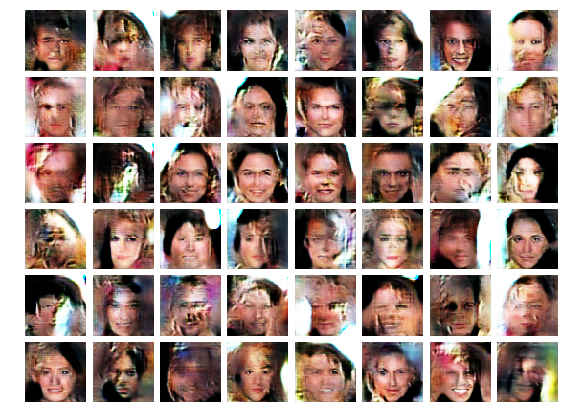

In [0]:
images_num = 80
noise_size = 100

rows, cols = 6, 8
sampled_labels = np.array([0.0 if i >= rows*cols/2 else 1.0 for i in range(rows*cols)])
noise = np.random.normal(size=(rows*cols, noise_size))
sample_imgs_(generator, noise, sampled_labels, noise_size)
# samples_gen = samples_generator(generator, images_num, num_class=2)

### Interpolate between images

In [0]:
# you can change these two
im_1 = 2, 3
im_2 = 3, 7

im_1 = cols * im_1[0] + im_1[1]
im_2 = cols * im_2[0] + im_2[1]

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


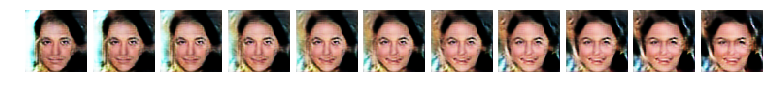

In [0]:
N = 10
rows, cols = 1, N+1
alphas = [i/N for i in range(N + 1)]
print(alphas)

interpolation_noise = [alpha * noise[im_1] + (1.0 - alpha) * noise[im_2] for alpha in alphas]
interpolation_noise = np.array(interpolation_noise)

interpolation_labels = [alpha * sampled_labels[im_1] + (1.0 - alpha) * sampled_labels[im_2] for alpha in alphas]
interpolation_labels = np.array(interpolation_labels)

interpolation_sample_imgs(generator, interpolation_noise, np.zeros(interpolation_noise.shape[0]), noise_size)

In [0]:
#@title Plot interpolation
HTML(plot_results(*plot_inter(get_inter_imgs(im_1, im_2, noise, classes, generator)), inches=2).to_jshtml())

In [0]:
class AnimObject(object):
    def __init__(self, images):
        print(len(images))
        self.fig, self.ax = plt.subplots()
        self.ax.set_title("")
        self.fig.set_size_inches((8, 8))
        self.plot = plt.imshow(images[0])
        plt.tight_layout()
        self.images = images
        
    def init(self):
        self.plot.set_data(self.images[0])
        self.ax.grid(False)
        return (self.plot,)
      
    def animate(self, i):
        self.plot.set_data(self.images[i])
        self.ax.grid(False)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_title("index {}".format(i))
        return (self.plot,)

def get_figures(template, indices):
    import os.path
    images = []
    for index in indices:
        if os.path.isfile(template.format(index)):
            images.append(Image.open(template.format(index)))
    return images


interpolation_images = generator.predict([interpolation_noise, interpolation_labels])
interpolation_images = interpolation_images/2.0 + 0.5
print(interpolation_images.shape)
print(type(interpolation_images))


images = [Image.fromarray(interpolation_images[i,:,:,:].astype('uint8')) for i in range(interpolation_images.shape[0])]
animobject = AnimObject(images)
anim = animation.FuncAnimation(
              animobject.fig,
              animobject.animate,
              frames=len(animobject.images),
              interval=150,
              blit=True)


In [0]:
HTML(anim.to_jshtml())